<a href="https://colab.research.google.com/github/ajankowi/Praca_inz/blob/master/Siec/Zlaczone_siec_4_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
print(sys.version)

3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]


In [2]:
#from google.colab import drive
#drive.mount("/content/drive", force_remount=True)

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, regularizers
from keras.layers import Flatten, add, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping


print("TensorFlow version:", tf.__version__)
tf.keras.backend.set_floatx('float64')

TensorFlow version: 2.9.2


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import os
import csv
import random

import cv2
import imutils
import glob
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [5]:
#Określenie ścieżek do plików
test_zip = '/content/drive/MyDrive/Sieci/Baza_zdjec_zlaczone_2/Test.zip'
test_csv = 'test.csv'

train_zip = '/content/drive/MyDrive/Sieci/Baza_zdjec_zlaczone_2/Train.zip'
train_csv = 'train.csv'

folder = '/content/drive/MyDrive/Sieci/Baza_zdjec_zlaczone_2/'
slesh = '/'
png = '.png'

In [6]:
#!unzip '/content/drive/MyDrive/Sieci/Baza_zdjec_zlaczone_2/Train.zip' -d '/content/train/'
#!unzip '/content/drive/MyDrive/Sieci/Baza_zdjec_zlaczone_2/Test.zip' -d '/content/test/'

In [7]:
def release_list(a):
    
    del a[:]
    del a

In [8]:
#Wczytanie etykiet do treninegu 

with open(folder+train_csv,"r") as csvfile:
    lines = csvfile.readlines()
csvfile.close()

new = []

for i in lines:
    new.append(i.split(" "))

    
value_train = []
for i in new[0]:
    value_train.append(int(i))    
    
print(len(value_train))

22680


In [9]:
#Wczytanie etykiet do testowania

with open(folder+test_csv,"r") as csvfile:
    lines = csvfile.readlines()
csvfile.close()

new = []

for i in lines:
    new.append(i.split(" "))

    
value_test = []
for i in new[0]:
    value_test.append(int(i))    
    
print(len(value_test))

2520


In [10]:
#Wczytanie zdjęć treningowych 
images_train = []
size = len(value_train)

for i in range(size):
    im = Image.open('/content/train/'+str(i)+'.png')
    arr_im = np.array(im) 
    arr_im = arr_im / 255.0
    images_train.append(arr_im) 
print(len(images_train))

22680


In [11]:
#Wczytanie zdjęć testowych 
images_test = []
size = len(value_test)

for i in range(size):
    im = Image.open('/content/test/'+str(i)+'.png')
    arr_im = np.array(im) 
    arr_im = arr_im / 255.0
    images_test.append(arr_im) 
print(len(images_test))

2520


In [12]:
x_train = np.array(images_train)
x_test = np.array(images_test)

y_train = np.array(value_train)
y_test = np.array(value_test)

In [15]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 128, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.1)))
model.add(layers.Dense(1, activation='relu'))


In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 126, 32)       320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 61, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 30, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 14, 30, 32)       128       
 hNormalization)                                                 
                                                      

In [17]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy','mse'])

#Funcka umożliwia zatrzymanie się uczenia 
#gdy wartość strat przstanie maleć
EarlyStop = EarlyStopping(monitor='val_loss',  
                          verbose=1, 
                          patience=10)


ModelCheck = ModelCheckpoint(filepath='/content/drive/MyDrive/Sieci/Zlaczone.h5',
                             monitor='val_loss',
                             save_best_only=True)


history = model.fit(x=x_train, 
                    y=y_train, 
                    epochs=100,
                    batch_size=128,
                    validation_split=0.1,
                    #validation_data = (x_test, y_test),
                    callbacks = [EarlyStop, ModelCheck]
                   )

Epoch 1/100
160/160 [==============================] - 27s 143ms/step - loss: 2.4577 - accuracy: 0.8776 - mse: 0.1143 - val_loss: 0.4716 - val_accuracy: 0.0000e+00 - val_mse: 0.3995
Epoch 2/100
160/160 [==============================] - 22s 136ms/step - loss: 0.0547 - accuracy: 0.9848 - mse: 0.0234 - val_loss: 0.6314 - val_accuracy: 0.0000e+00 - val_mse: 0.6130
Epoch 3/100
160/160 [==============================] - 22s 137ms/step - loss: 0.0292 - accuracy: 0.9940 - mse: 0.0143 - val_loss: 0.6416 - val_accuracy: 0.0617 - val_mse: 0.6284
Epoch 4/100
160/160 [==============================] - 23s 145ms/step - loss: 0.0204 - accuracy: 0.9976 - mse: 0.0093 - val_loss: 0.2433 - val_accuracy: 0.6177 - val_mse: 0.2343
Epoch 5/100
160/160 [==============================] - 23s 145ms/step - loss: 0.0186 - accuracy: 0.9970 - mse: 0.0091 - val_loss: 0.0447 - val_accuracy: 0.9511 - val_mse: 0.0355
Epoch 6/100
160/160 [==============================] - 22s 138ms/step - loss: 0.0131 - accuracy: 0.998

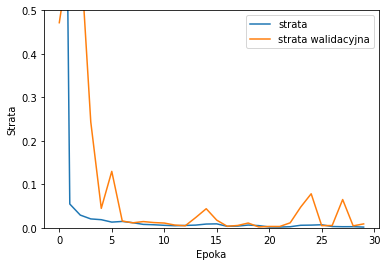

In [18]:
plt.plot(history.history['loss'], label='strata')
plt.plot(history.history['val_loss'], label = 'strata walidacyjna')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.ylim([0.0, 0.5])
plt.legend(loc='upper right')

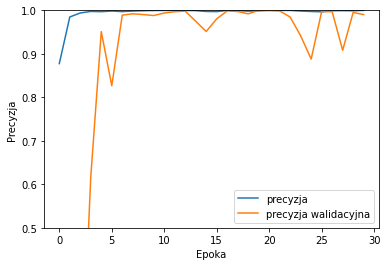

In [19]:
plt.plot(history.history['accuracy'], label='precyzja')
plt.plot(history.history['val_accuracy'], label = 'precyzja walidacyjna')
plt.xlabel('Epoka')
plt.ylabel('Precyzja')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [20]:
best_model = tf.keras.models.load_model('/content/drive/MyDrive/Sieci/Zlaczone.h5')


In [21]:
best_model.evaluate(x_test,  y_test, verbose=2)

79/79 - 1s - loss: 0.2467 - accuracy: 0.7353 - mse: 0.2454 - 1s/epoch - 18ms/step


[0.24669668950693258, 0.7353174603174604, 0.24541429173517965]

In [22]:
predict_x = best_model.predict(x_test) 

predictions = (predict_x > 0.5).astype("int32")

79/79 [==============================] - 1s 11ms/step


In [23]:
names = [['Tn','Nn'],['Np', 'Tp']]
names = np.reshape(names,(2,2))
print(names)

conf = tf.math.confusion_matrix(y_test,predictions)

print(conf)

[['Tn' 'Nn']
 ['Np' 'Tp']]
tf.Tensor(
[[ 593  667]
 [   0 1260]], shape=(2, 2), dtype=int32)
